In [ ]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp  


import numpy as np  
import matplotlib.pyplot as plt

from asterias.core import LimbDarkeningCoefficients

In [ ]:
filename = "sensitivity_files/JWST_NIRSpec_Prism_throughput.csv"
prism_throughput = np.genfromtxt(filename, delimiter=",", names=True)
ld = LimbDarkeningCoefficients(
    wavelength_ranges=jnp.array([[6000, 7000], [7000, 8000]]),
    filter_wavelengths=jnp.array(prism_throughput["wave"]),
    filter_throughput=jnp.array(prism_throughput["tp"]),
    mh_lower_limit=-0.3,
    mh_upper_limit=0.3,
    teff_lower_limit=4500,
    teff_upper_limit=5200,
    logg_lower_limit=4.0,
    logg_upper_limit=5,
    stellar_grid="mps1",
    poly_deg=6,
    ld_data_path="data",
    verbose=True,
)

Checking for/downloading 832 files


'/home/bc838/scratch_pi_mpr49/bc838/data/mps1/MH-0.1/teff4700/logg4.5/mps1_spectra.dat'

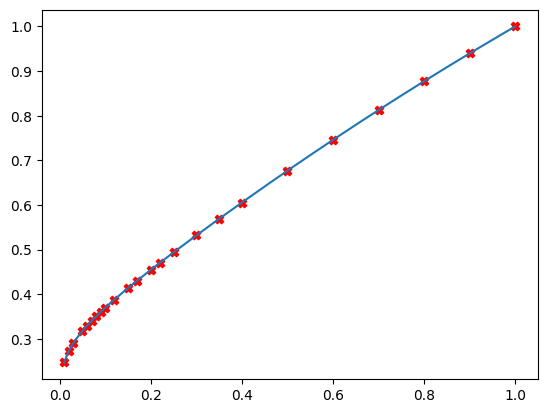

In [4]:
star_file = 20
plt.plot(ld.dense_mus, ld.interpolated_profiles[star_file,0,:])
plt.scatter(ld.mus, ld.stellar_profiles[star_file,0,:], marker="X", c="r")
ld.stellar_files[star_file]

In [5]:
coeffs_poly, coeffs_ld = ld.get_ldcs(mh=0.2, teff=5000.0, logg=4.0)
coeffs_poly, coeffs_ld

(Array([[ -5.16948917,  17.58005613, -23.55842331,  15.80493106,
          -5.7113242 ,   1.80569051,   0.24655759],
        [ -5.60395244,  19.0701516 , -25.60135207,  17.25282406,
          -6.28803959,   1.86471345,   0.30347804]], dtype=float64),
 Array([[  0.47690798,   1.22633502,  -5.57667982,  12.57004525,
         -12.98296571,   5.03979969],
        [  0.40074257,   1.31868294,  -6.0501019 ,  13.62414478,
         -14.05983319,   5.46288677]], dtype=float64))

In [6]:
coeffs_poly.shape, coeffs_ld.shape

((2, 7), (2, 6))

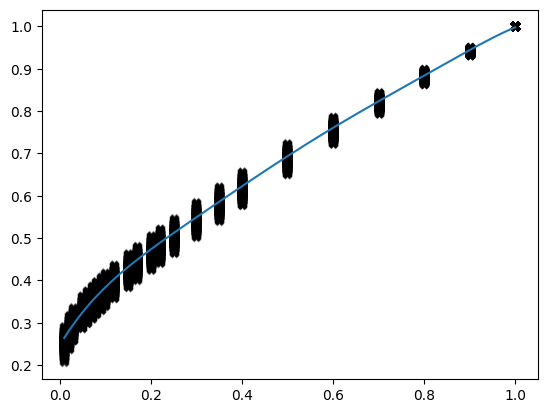

In [5]:
model = jnp.polyval(p=coeffs_poly[0], x=ld.dense_mus)
plt.plot(ld.dense_mus, model)
for s in range(len(ld.stellar_files)):
    plt.scatter(ld.mus, ld.stellar_profiles[s,0,:], marker="X", c="k", alpha=0.1)


np.float64(-1.0000003830185458)

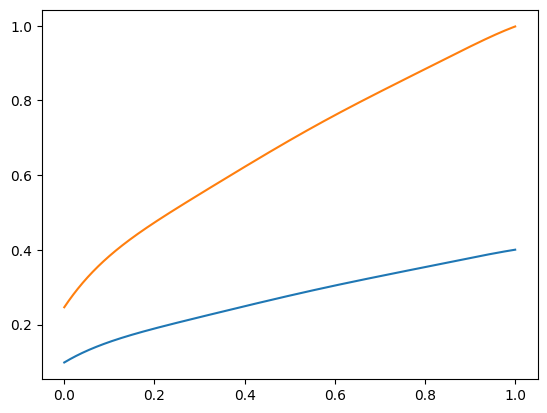

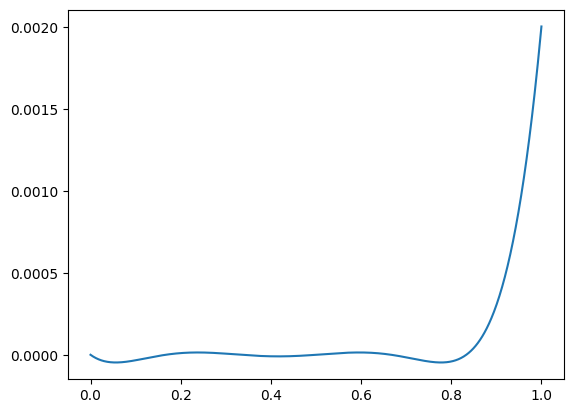

In [8]:
# the coefficients are normalized to be 1 at the center,
# and are assuming you're using a polynomial in mu.
# packages like squishyplanet and jaxoplanet assume you are working in
# 1 - c1 (1-mu) - c2 (1-mu)^2 - ...
# also, they're normalized differently so the integrated intensity is 1

# squishyplanet isn't required, just a dev dependency
from squishyplanet import OblateSystem
from scipy.integrate import simpson

mus = jnp.linspace(0, 1, 1000)
ld_profile = OblateSystem.limb_darkening_profile(coeffs_ld[0], mu=mus)
plt.plot(mus, ld_profile)

plt.plot(mus, jnp.polyval(p=coeffs_poly[0], x=mus))

plt.figure()
plt.plot(mus, ld_profile/ld_profile[-1] - jnp.polyval(p=coeffs_poly[0], x=mus))

rs = jnp.sqrt(1 - mus**2)
simpson(y = ld_profile * rs * 2 * jnp.pi, x=rs)

In [ ]:
# can differentiate w.r.t. any of the stellar parameters
jax.jacfwd(ld.get_ldcs, argnums=(0,1,2))(0.2, 5000.0, 4.0)

((Array([[-0.33009081,  1.19583229, -1.76536617,  1.35479257, -0.54221727,
           0.11242651, -0.0254977 ],
         [-0.41588105,  1.46775138, -2.09404099,  1.54714468, -0.60775342,
           0.12803826, -0.02541961]], dtype=float64),
  Array([[-7.05547844e-04,  2.29216956e-03, -2.86043487e-03,
           1.75392888e-03, -6.43929591e-04,  1.31087739e-04,
           3.24450858e-05],
         [-5.72328858e-04,  1.87043099e-03, -2.34321645e-03,
           1.42820849e-03, -5.06919804e-04,  9.47596995e-05,
           2.88513416e-05]], dtype=float64),
  Array([[ 0.23745951, -0.80690664,  1.07713108, -0.71971689,  0.25912675,
          -0.04873265,  0.00172464],
         [ 0.28509858, -0.96986862,  1.29719259, -0.86648244,  0.30725901,
          -0.05540549,  0.00231165]], dtype=float64)),
 (Array([[ 0.03129409,  0.05328496, -0.32357825,  0.69958528, -0.75736585,
           0.32227746],
         [ 0.02363508,  0.07821461, -0.43368179,  0.9428646 , -0.99107757,
           0.40546467]], d